# SageMaker Image Classification Built-In Algorithm

## Introduction 
The Amazon SageMaker image classification algorithm is a supervised learning algorithm that supports multi-label classification. It takes an image as input and outputs one or more labels assigned to that image. It uses a convolutional neural network (ResNet) that can be trained from scratch or trained using transfer learning when a large number of training images are not available.

The outline of this notebook is 

1. Prepare images into RecordIO format

2. Train the SageMaker Image Classification built-in algorithm 

3. Create and deploy the model to an endpoint for doing inference 

4. Test realtime inference with the endpoint

5. Do batch inference using SageMaker Batch Transform

Lets start by importing some base libraries and some initial variables

In the cell below, replace **'your-unique-bucket-name'** with the name of bucket you created in the data-prep notebook

In [7]:
%%time
import boto3
import os
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket = 'your-unique-bucket-name'

training_image = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='image-classification')

CPU times: user 783 ms, sys: 332 ms, total: 1.12 s
Wall time: 2.33 s


Install mxnet so we can use some of the tools to create RecordIO format datasets

In [2]:
! git clone https://github.com/apache/incubator-mxnet.git

Cloning into 'incubator-mxnet'...
remote: Enumerating objects: 131958, done.
remote: Counting objects: 100% (3250/3250), done.
remote: Compressing objects: 100% (1897/1897), done.
remote: Total 131958 (delta 1828), reused 2217 (delta 1328), pack-reused 128708
Receiving objects: 100% (131958/131958), 93.85 MiB | 31.97 MiB/s, done.
Resolving deltas: 100% (91882/91882), done.


## Data Preparation

Lets first list out the folders in our data folder 

In [3]:
! ls -1 ../data

test
train
val


Now we create a folder to store our RecordIO files

In [4]:
! mkdir recordio_dataset

We will now build our train and validation datasets in recordio format
First we generate list files using im2rec.py from mxnet <br>
The output will show the class label and its assigned number (implied from the folder structure)<br>
i.e.<br>
Priority 0<br>
Roundabout 1<br>
Signal 2

In [2]:
! python incubator-mxnet/tools/im2rec.py recordio_dataset/train ../data/train --recursive --list --num-thread 8

Priority 0
Roundabout 1
Signal 2


In [3]:
! python incubator-mxnet/tools/im2rec.py recordio_dataset/validation ../data/val --recursive --list --num-thread 8

Priority 0
Roundabout 1
Signal 2


Now we have generated the list files, we will use them to generate the respective training and validation recordio files

In [4]:
! python incubator-mxnet/tools/im2rec.py recordio_dataset/train.lst ../data/train 

Creating .rec file from /home/ec2-user/SageMaker/pssummitwkshp/sm_image_class/recordio_dataset/train.lst in /home/ec2-user/SageMaker/pssummitwkshp/sm_image_class/recordio_dataset
multiprocessing not available, fall back to single threaded encoding
time: 0.4047524929046631  count: 0
time: 15.54312515258789  count: 1000


In [5]:
! python incubator-mxnet/tools/im2rec.py recordio_dataset/validation.lst ../data/val

Creating .rec file from /home/ec2-user/SageMaker/pssummitwkshp/sm_image_class/recordio_dataset/validation.lst in /home/ec2-user/SageMaker/pssummitwkshp/sm_image_class/recordio_dataset
multiprocessing not available, fall back to single threaded encoding
time: 0.0166780948638916  count: 0


Now we have the train and validation datasets in recordio format, we will now copy them to our S3 bucket 

In [8]:
s3_train_key = "recordio_dataset/train"
s3_validation_key = "recordio_dataset/validation"
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)

In [9]:
! aws s3 cp recordio_dataset/train.lst {s3_train}
! aws s3 cp recordio_dataset/train.rec {s3_train}
! aws s3 cp recordio_dataset/train.idx {s3_train}
! aws s3 cp recordio_dataset/validation.lst {s3_validation}
! aws s3 cp recordio_dataset/validation.rec {s3_validation}
! aws s3 cp recordio_dataset/validation.idx {s3_validation}

upload: recordio_dataset/train.lst to s3://myagm-dcsum/recordio_dataset/train/train.lst
upload: recordio_dataset/train.rec to s3://myagm-dcsum/recordio_dataset/train/train.rec
upload: recordio_dataset/train.idx to s3://myagm-dcsum/recordio_dataset/train/train.idx
upload: recordio_dataset/validation.lst to s3://myagm-dcsum/recordio_dataset/validation/validation.lst
upload: recordio_dataset/validation.rec to s3://myagm-dcsum/recordio_dataset/validation/validation.rec
upload: recordio_dataset/validation.idx to s3://myagm-dcsum/recordio_dataset/validation/validation.idx


## Training
Lets now define our hyperparameter values for training the Image Classification algorithm

In [11]:
# For this training, we will use 50 layers
num_layers = "18" 
# we need to specify the input image shape for the training data
image_shape = "3,640,640"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "1334"
# specify the number of output classes
num_classes = "3"
# batch size for training
mini_batch_size =  "64"
# number of epochs
epochs = "50"
# learning rate
learning_rate = "0.01"

We will now set up the hyperparameters and define our training and valiadation channels

In [12]:
%%time
import time
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name
job_name_prefix = 'traffic-image-classification'
job_name = job_name_prefix + '-' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: traffic-image-classification--2021-09-17-17-25-27

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://myagm-dcsum/recordio_dataset/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 56.3 ms, sys: 11.2 ms, total: 67.6 ms
Wall time: 74.5 ms


We now run the training job and wait until it completes - runs for 15-20 minutes

In [13]:
%%time
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed
CPU times: user 187 ms, sys: 17.3 ms, total: 204 ms
Wall time: 16min 1s


The training job is launched asynchronously. The get_waiter method waits until the job finishes then calls the describe_training_job to get the current status of the job

In [14]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Create Endpoint Configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create Endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform Inference](#PerformInference) - Perform inference on some input data using the endpoint.

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [21]:
%%time
import boto3
from time import gmtime, strftime
sage = boto3.Session().client(service_name='sagemaker') 

model_name="DEMO-full-image-classification-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-full-image-classification-model
s3://myagm-dcsum/traffic-image-classification/output/traffic-image-classification--2021-09-17-17-25-27/output/model.tar.gz
arn:aws:sagemaker:us-east-1:826659556017:model/demo-full-image-classification-model
CPU times: user 83.5 ms, sys: 12.2 ms, total: 95.6 ms
Wall time: 549 ms


### Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [22]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: traffic-image-classification-epc--2021-09-17-18-08-57
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:826659556017:endpoint-config/traffic-image-classification-epc--2021-09-17-18-08-57


### Create Endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [23]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: traffic-image-classification-ep--2021-09-17-18-09-05
EndpointArn = arn:aws:sagemaker:us-east-1:826659556017:endpoint/traffic-image-classification-ep--2021-09-17-18-09-05
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 254 ms


Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [24]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

## Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [25]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

### Download test image

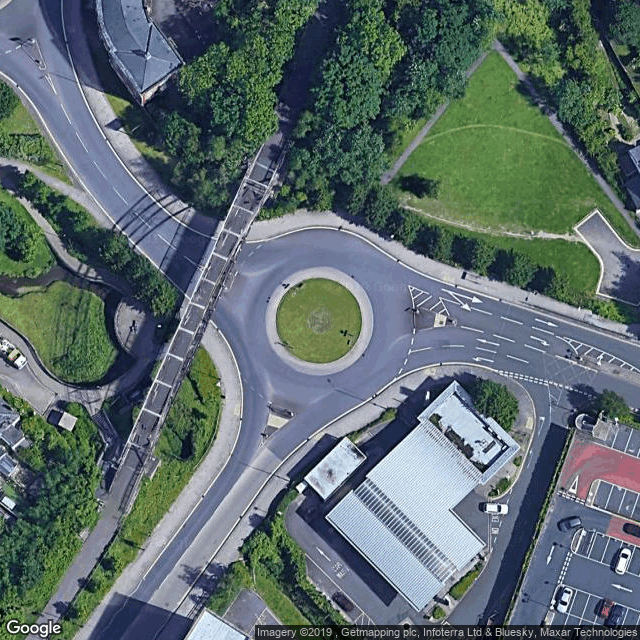

In [26]:
file_name = '../data/test/Roundabout/R2.png'
# test image
from IPython.display import Image
Image(file_name)  

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for a couple of epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [27]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)

[0.00032262507011182606, 0.9989961981773376, 0.0006811840576119721]


### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [28]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '62f31da9-7ed9-4265-a3b0-e6513fc0147b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '62f31da9-7ed9-4265-a3b0-e6513fc0147b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 17 Sep 2021 18:19:08 GMT'},
  'RetryAttempts': 0}}

## Batch Inference
We are going to use SageMaker Batch Transform to run batch inference on the Test dataset provided

In [15]:
%%time
import sagemaker

sage = boto3.Session().client(service_name='sagemaker') 

model_name="traffic-full-image-classification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

traffic-full-image-classification-model-2021-09-17-17-46-47
s3://myagm-dcsum/traffic-image-classification/output/traffic-image-classification--2021-09-17-17-25-27/output/model.tar.gz
arn:aws:sagemaker:us-east-1:826659556017:model/traffic-full-image-classification-model-2021-09-17-17-46-47
CPU times: user 91.2 ms, sys: 15.1 ms, total: 106 ms
Wall time: 549 ms


Copy the test images to your S3 bucket

In [16]:
batch_input = f's3://{bucket}/test/'

In [17]:
! aws s3 cp ../data/test/ {batch_input} --recursive

upload: ../data/test/Roundabout/R2.png to s3://myagm-dcsum/test/Roundabout/R2.png
upload: ../data/test/Roundabout/R1.png to s3://myagm-dcsum/test/Roundabout/R1.png
upload: ../data/test/Signal/X1.png to s3://myagm-dcsum/test/Signal/X1.png
upload: ../data/test/Roundabout/R3.png to s3://myagm-dcsum/test/Roundabout/R3.png
upload: ../data/test/Priority/P1.png to s3://myagm-dcsum/test/Priority/P1.png
upload: ../data/test/Signal/S2.png to s3://myagm-dcsum/test/Signal/S2.png
upload: ../data/test/Signal/S1.png to s3://myagm-dcsum/test/Signal/S1.png
upload: ../data/test/Priority/P2.png to s3://myagm-dcsum/test/Priority/P2.png


Setup the parameters for this batch transform job

In [18]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "traffic-image-classification-model" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p3.2xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(batch_input))

Transform job name: traffic-image-classification-model-2021-09-17-17-48-03

Input Data Location: s3://myagm-dcsum/test/


Now lets run the batch transform job and wait for completion - takes 5-10 minutes 

In [19]:
%%time
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)

Created Transform job with name:  traffic-image-classification-model-2021-09-17-17-48-03
Transform job ended with status: Completed
CPU times: user 314 ms, sys: 2.71 ms, total: 317 ms
Wall time: 7min 1s


Let us now look at the result of the predictions for each image together with thier confidence rating. 
Note that we have to map the class numbers back to the label assignments

In [20]:
import json
import numpy as np
from urllib.parse import urlparse

s3_client = boto3.client('s3')
object_categories = ['Priority','Roundabout','Signal'] 

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Filename: " + filename + " Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:10]]

Sample inputs: ['test/Priority/.ipynb_checkpoints/P1-checkpoint.png', 'test/Priority/P1.png']
Sample output: ['traffic-image-classification-model-2021-09-17-17-48-03/output/Priority/.ipynb_checkpoints/P1-checkpoint.png.out', 'traffic-image-classification-model-2021-09-17-17-48-03/output/Priority/P1.png.out']
Filename: P1-checkpoint.png.out Result: label - Priority, probability - 0.9996637105941772
Filename: P1.png.out Result: label - Priority, probability - 0.9996637105941772
Filename: P2.png.out Result: label - Priority, probability - 0.9994206428527832
Filename: R1-checkpoint.png.out Result: label - Roundabout, probability - 0.9991771578788757
Filename: R2-checkpoint.png.out Result: label - Roundabout, probability - 0.9989961981773376
Filename: R3-checkpoint.png.out Result: label - Roundabout, probability - 0.9897502064704895
Filename: R1.png.out Result: label - Roundabout, probability - 0.9991771578788757
Filename: R2.png.out Result: label - Roundabout, probability - 0.9989961981773

[('Priority', 0.9996637105941772),
 ('Priority', 0.9996637105941772),
 ('Priority', 0.9994206428527832),
 ('Roundabout', 0.9991771578788757),
 ('Roundabout', 0.9989961981773376),
 ('Roundabout', 0.9897502064704895),
 ('Roundabout', 0.9991771578788757),
 ('Roundabout', 0.9989961981773376),
 ('Roundabout', 0.9897502064704895),
 ('Signal', 0.9998956918716431)]